# Homework 03 - Neural Network
10/07/2022
Projects in Machine Learning

Author: Matt Uryga

## Task 1

I have utilized PyTorch extensively in the past, but it has been a few months since I've coded any PyTorch code.  As such, I am a bit rusty with the function arguments and such.

I relied on the PyTorch documentation (https://pytorch.org/docs/stable/index.html) heavily throughout the assignment.
I also referenced the code found on https://github.com/zalandoresearch/fashion-mnist for importing Fashion-MNIST data using torchvision.
Generally, though, I am quite familliar with PyTorch and how to use it to train a simple neural network, so there wasn't too much that I had to research for this assignment.

## Task 2

In [16]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [17]:
# constants
num_workers = 8
batch_size = 5000
num_epochs = 200
learning_rate = 0.01
progress_bar = True

# get device
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

using device: cuda:0


### Exploratory Data Analysis

In [18]:
# load datasets
train_dataset = torchvision.datasets.FashionMNIST("./data", download = True, transform = transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("./data", download = True, train = False, transform = transforms.Compose([transforms.ToTensor()]))

In [19]:
# print sizes of datasets
print('Before Split')
print(f'\t{len(train_dataset) = }')
print(f'\t{len(test_dataset) = }')

Before Split
	len(train_dataset) = 60000
	len(test_dataset) = 10000


In [20]:
# no validation/dev set, so we create one from training data
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

# print sizes of datasets
print('After Split')
print(f'\t{len(train_dataset) = }')
print(f'\t{len(valid_dataset) = }')
print(f'\t{len(test_dataset) = }')

After Split
	len(train_dataset) = 50000
	len(valid_dataset) = 10000
	len(test_dataset) = 10000


In [21]:
# initialize dataloaders
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size)

# print shape of batch
print(f'Batch Shape = {next(iter(train_loader))[0].shape}')

Batch Shape = torch.Size([5000, 1, 28, 28])


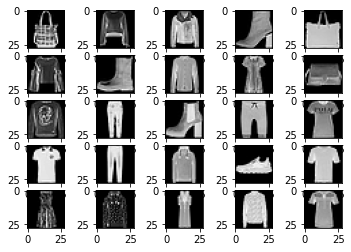

<Figure size 432x288 with 0 Axes>

In [29]:
# display some images
fig, ax = plt.subplots(5,5)
for i in range(0, 5):
	for j in range(0, 5):
		ax[i][j].imshow(train_dataset[5*i+j][0].squeeze(), cmap='gray')
plt.show()
plt.clf()

In [39]:
print('Image pixel range:')
print(torch.min(train_dataset[0][0].squeeze()))
print(torch.max(train_dataset[0][0].squeeze()))

Image pixel range:
tensor(0.)
tensor(1.)


There is a 50,000, 10,000, 10,000 split for the training, validation, and test sets.
Each data point consists of a 28x28 grayscale image with pixels that range from 0 to 1; from the Github (https://github.com/zalandoresearch/fashion-mnist), we know that there are 10 classes, labeled 0 through 10.

No data processing is needed in this situation - we will pass each pixel as a discrete input into the input layer of the model.

In [23]:
class FFN_Model(nn.Module):
	'''
	simple feed forward network
	'''
	def __init__(self, in_dim, out_dim):
		super().__init__()
		# flatten images to 1d tensor
		self.flatten = nn.Flatten()

		# 2 fully connected layers
		self.fc1 = nn.Linear(in_dim, in_dim)
		self.fc2 = nn.Linear(in_dim, out_dim)

		# dropout layer
		self.dropout = nn.Dropout()

	def forward(self, x):
		'''
		forward pass function
		'''

		# flatten image
		x = self.flatten(x)

		# pass through both linear layers with dropout in between
		# through experimentation, it was found that no activation function produced the model
		# with the best accuracy
		# softmax, sigmoid, relu we all tried and none produced results better than no activation function
		return self.fc2(self.dropout(self.fc1(x)))

In [24]:
# create model
# hyperparameters:
# in_dim is 784 -> number of pixels in image - each pixel is its own input
# out_dim is 10 -> one for each class representing how likely each class is based on the input image
model = FFN_Model(784, 10)
model = model.to(device)

# initialize optimizer
# Adam optimizer is used -> had best preformance
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# initialize loss function
# utilize cross entropy loss
loss_func = nn.CrossEntropyLoss()

# prev_loss is used to store validation losses -> training is stopped
# once validation loss is above a 5-epoch rolling mean
prev_loss = []

In [25]:
# iterate for specified number of epochs
for epoch in range(num_epochs):
	model.train()
	sum_loss = 0
	for batch_idx, (images, labels) in enumerate(tqdm(train_loader, disable = not progress_bar, desc = f'Epoch {epoch:02d}', ncols=100)):
		# send tensors to device
		images, labels = images.to(device), labels.to(device)

		# zero out gradients
		optimizer.zero_grad()

		# forward pass
		preds = model(images)

		# calculate loss
		loss = loss_func(preds, labels)
		sum_loss += loss.item()

		# backward pass
		loss.backward()

		# step optimizer
		optimizer.step()
	print(f'\tTrain loss =      {sum_loss/(batch_idx+1)/batch_size:.6f}')

	model.eval()
	valid_loss = 0
	with torch.no_grad():
		for batch_idx, (images, labels) in enumerate(valid_loader):
			# send tensors to device
			images, labels = images.to(device), labels.to(device)

			# forward pass
			preds = model(images)

			# calculate loss
			loss = loss_func(preds, labels)
			valid_loss += loss.item()

	# append current loss to prev_loss list
	prev_loss.append(valid_loss)

	print(f'\tValidation loss = {valid_loss/(batch_idx+1)/batch_size:.6f}')

	# if valid_loss exceedes the 5-epoch rolling sum, break from training
	if valid_loss > np.mean(prev_loss[-5:]):
		break

Epoch 00: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.62it/s]


	Train loss =      0.005341
	Validation loss = 0.002953


Epoch 01: 100%|█████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.36it/s]


	Train loss =      0.002789
	Validation loss = 0.001218


Epoch 02: 100%|█████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.31it/s]


	Train loss =      0.001346
	Validation loss = 0.000671


Epoch 03: 100%|█████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.40it/s]


	Train loss =      0.000633
	Validation loss = 0.000455


Epoch 04: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.63it/s]


	Train loss =      0.000409
	Validation loss = 0.000300


Epoch 05: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.64it/s]


	Train loss =      0.000279
	Validation loss = 0.000190


Epoch 06: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.64it/s]


	Train loss =      0.000190
	Validation loss = 0.000139


Epoch 07: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.66it/s]


	Train loss =      0.000150
	Validation loss = 0.000117


Epoch 08: 100%|█████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.70it/s]


	Train loss =      0.000130
	Validation loss = 0.000111


Epoch 09: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.63it/s]


	Train loss =      0.000119
	Validation loss = 0.000102


Epoch 10: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.64it/s]


	Train loss =      0.000111
	Validation loss = 0.000098


Epoch 11: 100%|█████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.67it/s]


	Train loss =      0.000106
	Validation loss = 0.000095


Epoch 12: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.63it/s]


	Train loss =      0.000102
	Validation loss = 0.000093


Epoch 13: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.54it/s]


	Train loss =      0.000099
	Validation loss = 0.000090


Epoch 14: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.51it/s]


	Train loss =      0.000095
	Validation loss = 0.000089


Epoch 15: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.52it/s]


	Train loss =      0.000094
	Validation loss = 0.000087


Epoch 16: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.60it/s]


	Train loss =      0.000093
	Validation loss = 0.000087


Epoch 17: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.55it/s]


	Train loss =      0.000091
	Validation loss = 0.000085


Epoch 18: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.67it/s]


	Train loss =      0.000089
	Validation loss = 0.000084


Epoch 19: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.66it/s]


	Train loss =      0.000089
	Validation loss = 0.000083


Epoch 20: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.57it/s]


	Train loss =      0.000087
	Validation loss = 0.000083


Epoch 21: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.59it/s]


	Train loss =      0.000087
	Validation loss = 0.000083


Epoch 22: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.55it/s]


	Train loss =      0.000086
	Validation loss = 0.000082


Epoch 23: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.63it/s]


	Train loss =      0.000085
	Validation loss = 0.000082


Epoch 24: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.57it/s]


	Train loss =      0.000085
	Validation loss = 0.000082


Epoch 25: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.50it/s]


	Train loss =      0.000084
	Validation loss = 0.000081


Epoch 26: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.47it/s]


	Train loss =      0.000083
	Validation loss = 0.000081


Epoch 27: 100%|█████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.56it/s]


	Train loss =      0.000083
	Validation loss = 0.000082


In [26]:
num_correct = 0
sum_loss = 0
with torch.no_grad():
	for batch_idx, (images, labels) in enumerate(tqdm(test_loader, disable = not progress_bar, desc = 'Testing', ncols=100)):
		# send tensors to device
		images, labels = images.to(device), labels.to(device)

		# forward pass
		preds = model(images)

		# calculate loss
		loss = loss_func(preds, labels)
		sum_loss += loss.item()

		# calculate accuracy
		preds = torch.argmax(preds, axis=1)
		num_correct += torch.sum(preds == labels)

Testing: 100%|████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.63it/s]


In [27]:
print(f'Testing:\n\tTest loss = {sum_loss/(batch_idx+1)/batch_size:.6f}')
print(f'\tTest Accuracy = {100*num_correct/len(test_dataset):.2f}%')

Testing:
	Test loss = 0.000091
	Test Accuracy = 84.37%


## Task 3

Hyperparameters were mostly chosen by testing.  The model is not computationally expensive to train, thus it is simple and quick to alter hyperparameters and observe the effects that they have on the model's performance.
It was found that 2 fully connected layers was the most effective for shorter training times, and that a batch size of 5,000 was optimal for training time.
A learning rate of 0.01 was used to maximize accuracy while keeping training time reasonably fast.

The Adam optimizer was found to produce the most accurate models, and as a result, it was chosen as the final optimizer to use.  Without an optimizer, the model takes far longer to train and produces poorer accuracy when compared to the model with the Adam optimizer.

For regularization, I chose to implement a dropout layer between the two linear layers.  This was to help reduce overfitting.

## Task 4

In [40]:
# Decision Tree
clf = LogisticRegression(max_iter = 100)

# get data
train_X = np.zeros((50000,784))
train_y = np.zeros((50000))
test_X = np.zeros((10000,784))
test_y = np.zeros((10000))

# process data into arrays
for i in range(len(train_dataset)):
	train_X[i] = train_dataset[i][0].flatten()
	train_y[i] = train_dataset[i][1]

for i in range(len(test_dataset)):
	test_X[i] = test_dataset[i][0].flatten()
	test_y[i] = test_dataset[i][1]

# train logistic classifier
clf.fit(train_X, train_y)

# get accuracy for logistic classifier
print(f'Logistic Regression Accuracy = {100*clf.score(test_X, test_y):.2f}%')

Logistic Regression Accuracy = 80.69%


C:\Users\mnury\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The neural network reached an accuracy of 84.37%, while the logistic regression model reached an accuracy of 80.69%.  These models have roughly the same accuracy across the testing dataset, with the neural network having a 3.8% edge over the regression.
The logistic regression trains faster, but it is not a wildly significant difference - it is noticable but it is not huge.

The neural network is able to perform better due to the large number of parameters and the vastly increased flexibility it has when compared to the logistic classifier.
The logistic classifier is not able to converge on a solution, most likely due to the complexity of the dataset - each data point is composed of 784 discrete pixels, and the neural network is able to interpret this better.